In [1]:
import sys
sys.path.append("../dataset/")
from dataset import UltraSoundImages

import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import matplotlib.colors as mcolors

In [2]:
from keras_unet_collection import losses

def custom_focal_tversky(y_true, y_pred, alpha=0.8, gamma=4/3):
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'custom_focal_tversky': custom_focal_tversky}

In [3]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [4]:
dataset_type = 'samsung'

def get_images(dataset_type):
    if dataset_type=='samsung':
        dataset_path = "../dataUSGthyroid/samsung_processed"
        divider = 15555.0
    elif dataset_type=='ge':
        dataset_path = "../dataUSGthyroid/GE_processed"
        divider = 255.0

    raw_images = dataset_path + "/images"
    raw_masks = dataset_path + "/masks"

    images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
    masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

    batch_size = 16
    size = (256, 256)

    images, masks = [], []
    for i in range(len(images_paths)):
        image, header = nrrd.read(images_paths[i])
        mask, header = nrrd.read(masks_paths[i])

        if size:
            image = tf.image.resize_with_pad(image, size[0], size[1])
            mask = tf.image.resize_with_pad(mask, size[0], size[1])

        if dataset_type=='ge':
            image = np.expand_dims(image[:,:,0], 2)
            mask = np.expand_dims(mask[:,:,0] , 2)

        images.append(image)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks) / divider
    return images, masks, images_paths

# Samsung

In [5]:
images, masks, paths = get_images('samsung')

In [6]:
model_path = 'output/u2net_2d/samsung/test/model/model'

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    predictions = model.predict(images) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [7]:
samsung_data = []
for image, mask, prediction, path in zip(images, masks, predictions, paths):
    dice_coef_value = dice_coef(mask, prediction)
    samsung_data.append({'path': path, 'dice_value': dice_coef_value, 'image':image, 'mask':mask, 'pred':prediction})
samsung_list = sorted(samsung_data, key=lambda x: x['dice_value'])

In [8]:
original_map = mcolors.LinearSegmentedColormap.from_list('original_mask', [(0, (0,0,0,0)), (1, 'yellow')])
pred_map = mcolors.LinearSegmentedColormap.from_list('pred_mask', [(0, (0,0,0,0)), (1, 'red')])

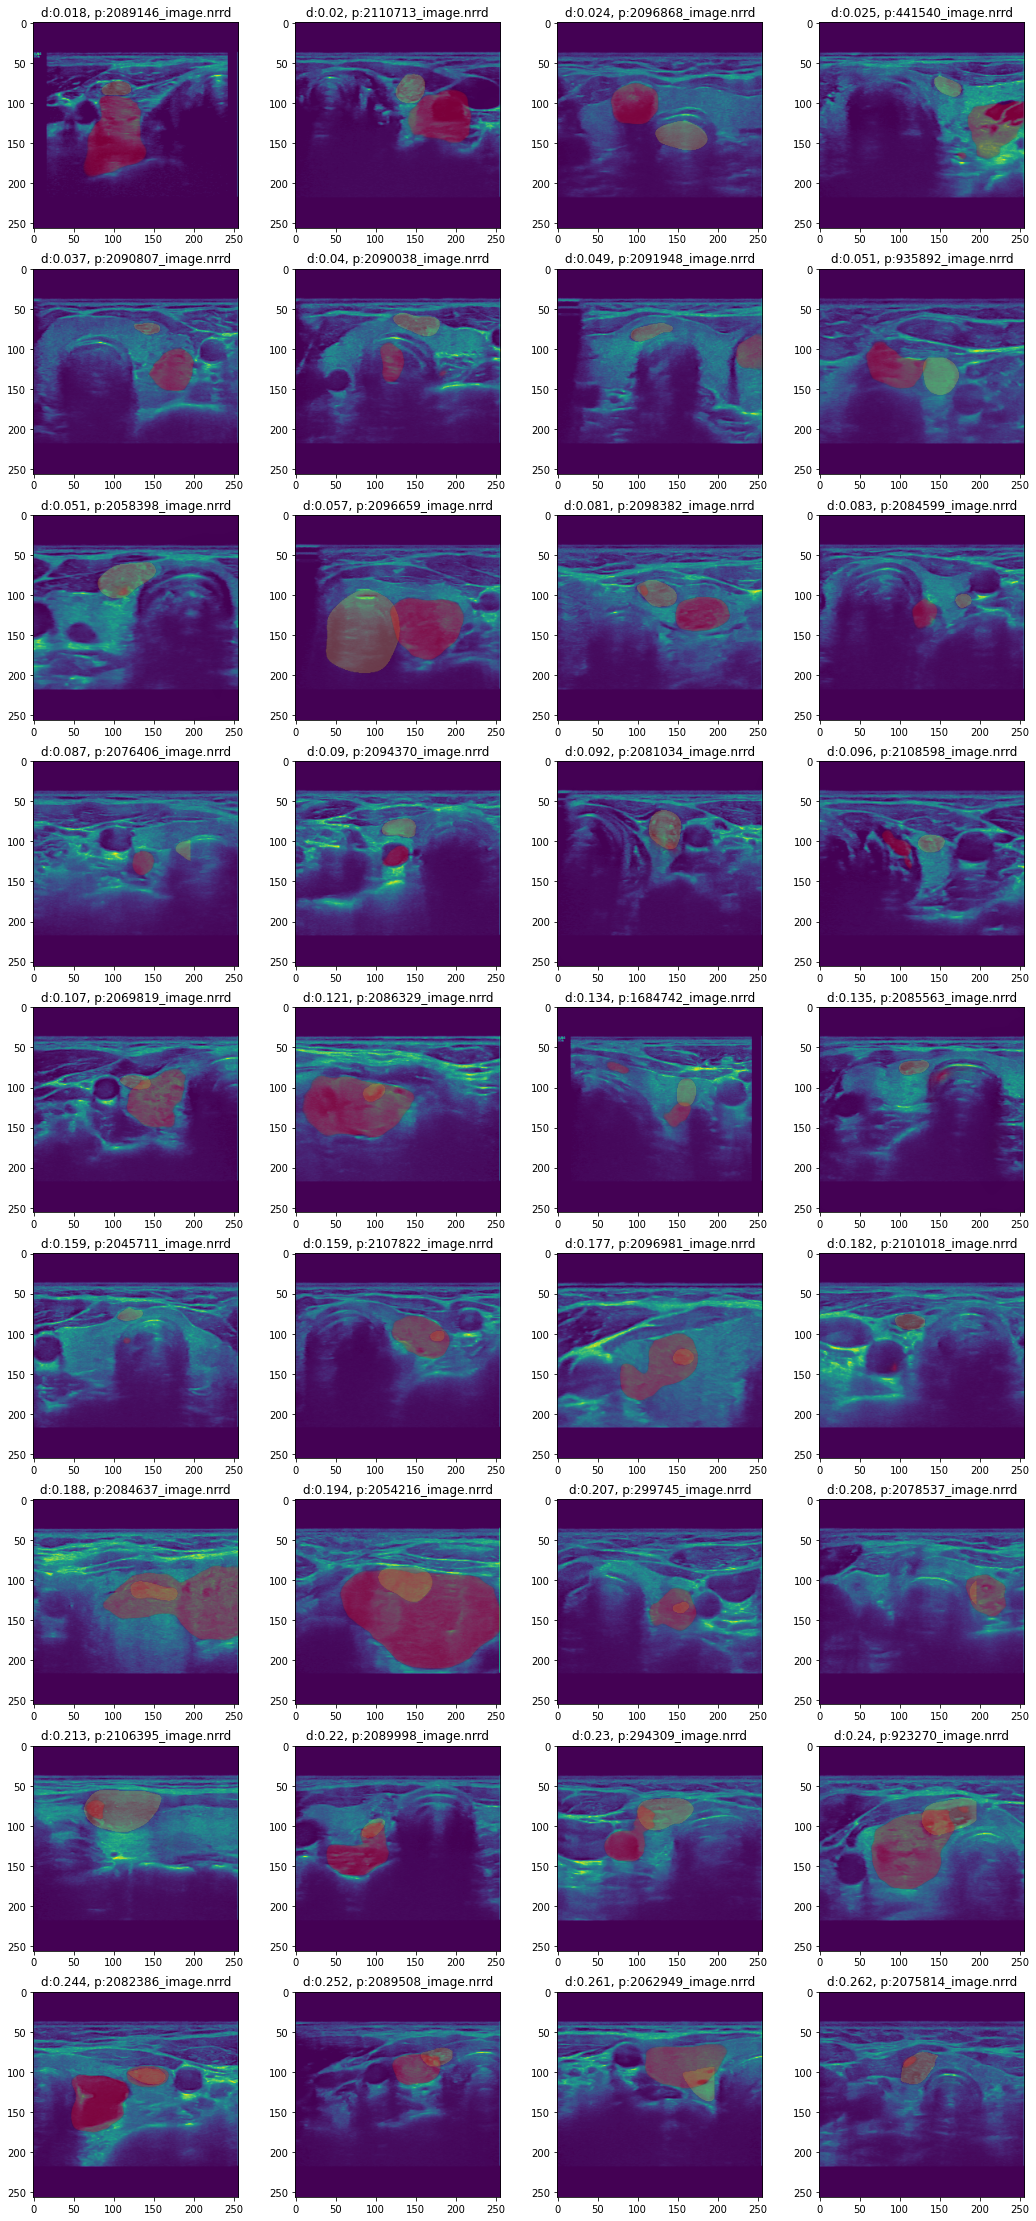

In [9]:
plt.figure(figsize=(18, 40))
for i in range(36):
    plt.subplot(9, 4, i+1)
    plt.imshow(samsung_list[i]['image']*2)
    plt.imshow(samsung_list[i]['mask'], alpha=0.2, cmap=original_map)
    plt.imshow(samsung_list[i]['pred'], alpha=0.3, cmap=pred_map)
    p = samsung_list[i]['path'].split('/')[-1]
    v = round(float(samsung_list[i]['dice_value']), 3)
    plt.title(f'd:{v}, p:{p}')

In [24]:
samsung_blacklist = [el['path'].split('/')[-1].split('_')[0] for el in samsung_list[:50]]

In [25]:
samsung_blacklist[:10]

['2089146',
 '2110713',
 '2096868',
 '441540',
 '2090807',
 '2090038',
 '2091948',
 '935892',
 '2058398',
 '2096659']

# GE

In [5]:
images, masks, paths = get_images('ge')

In [6]:
model_path = 'output/u2net_2d/ge/test/model/model'

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    predictions = model.predict(images) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [7]:
ge_data = []
for image, mask, prediction, path in zip(images, masks, predictions, paths):
    dice_coef_value = dice_coef(mask, prediction)
    ge_data.append({'path': path, 'dice_value': dice_coef_value, 'image':image, 'mask':mask, 'pred':prediction})
ge_list = sorted(ge_data, key=lambda x: x['dice_value'])

In [8]:
# ge_list = ge_list[::-1]

NameError: name 'original_map' is not defined

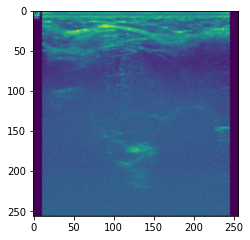

In [9]:
plt.figure(figsize=(18, 40))
for i in range(36):
    plt.subplot(9, 4, i+1)
    plt.imshow(ge_list[i]['image']*2)
    plt.imshow(ge_list[i]['mask'], alpha=0.2, cmap=original_map)
    plt.imshow(ge_list[i]['pred'], alpha=0.3, cmap=pred_map)
    p = ge_list[i]['path'].split('/')[-1]
    v = round(float(ge_list[i]['dice_value']), 3)
    plt.title(f'd:{v}, p:{p}')

In [ ]:
# np.unique(ge_list[0]['mask'])

In [10]:
ge_blacklist = [el['path'] for el in ge_list[:50]]

In [11]:
ge_blacklist

['../dataUSGthyroid/GE_processed/images/2061093_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1909699_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2026988_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2052396_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2051655_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2056390_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/176349_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1645263_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2060219_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/65544_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/258419_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2063235_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1465881_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/2058490_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1876319_image.nrrd',
 '../dataUSGthyroid/GE_processed/images/1875519_image.nrrd',
 '../dataUSGthyroid/GE_proce

In [ ]:
ge_blacklist = [el['path'].split('/')[-1].split('_')[0] for el in ge_list[:50]]

In [30]:
ge_blacklist[:10]

['2061093',
 '1909699',
 '2026988',
 '2052396',
 '2051655',
 '2056390',
 '176349',
 '1645263',
 '2060219',
 '65544']